## Modelo de Ising
<div style="text-align: justify">
El modelo de Ising es el modelo matemático del ferromagnetismo. Se parte de una grilla cuadrada de $N \times N$ elementos y se asigna a cada uno un espín $\uparrow (S=1)$ o $\downarrow (S=-1)$. Éstos interactúan con sus primeros vecinos con una energía de intercambio $J$ si son paralelos y $-J$ si son antiparalelos. <br>
El hamiltoniano del sistema es: <br><br>
$$
\mathcal{H} = -J \sum_{\langle i,j \rangle} S_iS_j - H \sum_i S_i
$$
<br> donde la notación $\langle i,j \rangle$ indica la suma sobre los primeros vecinos, $J$ es la energía de intercambio, $S_{i,j}$ es el espín y $H$ es la magnitud del campo magnético externo. <br>
La probabilidad de transición entre 2 estados $W_1$ y $W_2$ es: <br><br>
$$
P(W_1 \rightarrow W_2) = \left\{ \begin{matrix} 1 & \:\:\:\: si \:\: \Delta E_{W_1 \rightarrow W_2} \le 0 \\ \exp{(-\beta \cdot \Delta E_{W_1 \rightarrow W_2})} & \:\:\:\: si \:\: \Delta E_{W_1 \rightarrow W_2} > 0 \end{matrix} \right.
$$
<br> donde $\beta = \frac{1}{k_B T}$.
<br><br>
La forma básica para resolver el modelo de Ising es a través del algoritmo de Metrópolis: <ol>
<li> Preparar una configuración inicial de $N^2$ espines.
<li> Elegir un sitio aleatoriamente y calcular la contribución a la energía relacionada con su espín.
<li> Variar el espín de dicho sitio y calcular la nueva contribución a la energía.
<li> Calcular la variación de energía $dE$.
<li> Si $dE<0$ se acepta el cambio con probabilidad $1$. Si $dE>0$ se acepta el cambio con probabilidad $\exp{(-\beta \cdot dE)}$.
<li> Se repiten los pasos 2 a 5.
</ol> </div>

## Aleaciones binarias
<div style="text-align: justify">
Considerando interacciones a primeros vecinos en una red cuadrada en la que cada sitio está ocupado por un átomo de A o de B, el hamiltoniano de la red es: <br><br>
$$
\mathcal{H} = \sum_{\langle i,j \rangle} \biggl\{ V^{AA}c_ic_j + V^{AB} \Bigl[ c_i\bigl(1-c_j\bigr)+\bigl(1-c_i\bigr)c_j \Bigr] + V^{BB}\bigl(1-c_i\bigr)\bigl(1-c_j\bigr) \biggr\}
$$
<br> donde $V$ es la energía de unión entre los átomos indicados por su superíndice y $c_i$ es una variable que adopta valor $1$ si el sitio $i$ está ocupado por un átomo A y $0$ si está ocupado por un átomo B. <br>
Esto puede adaptarse al modelo de Ising a partir del siguiente cambio de variable: <br><br>
$$
S_i=2c_i-1
$$
<br> donde $S_i$ adopta valor $+1$ si el sitio $i$ está ocupado por un átomo A y $-1$ si está ocupado por un átomo B. De este modo, el hamiltoniano del sistema es: <br><br>
$$
\mathcal{H}_I = -J \sum_{\langle i,j \rangle} S_iS_j - H \sum_i S_i
$$
<br> donde $J$ queda determinada por: <br><br>
$$
J = -\frac{1}{4} \bigl( V^{AA}-2V^{AB}+V^{BB} \bigr)
$$
<br> y $H$, el equivalente al campo magnético externo, se define a partir de los potenciales químicos $\mu_A$ y $\mu_B$ según: <br><br>
$$
H = \frac{1}{2} \bigl( \mu_A-\mu_B \bigr) - \bigl( V^{AA}-V^{BB} \bigr)
$$
</div>

---
### Librerías

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.rc('font', size=14)

In [2]:
colors = [(247/256, 166/256, 0), (2/256, 63/256, 134/256)]
ElMasGrande = LinearSegmentedColormap.from_list('Boca', colors, 2)

### Datos

In [3]:
# Tamaño de la malla y proporción de átomos de A
N = 30
xA = 0.50

# Constantes del problema (no encontré valores recomendados o específicos de alguna aleación)
VAA = -1
VAB = -2
VBB = -1
muA = 0.2
muB = 0.8

# Temperaturas y movimientos de Montecarlo por temperatura
Temps = np.hstack((np.linspace(4, 1.5, 6), [1.4, 1.3, 1.2], np.linspace(1.19, 1.15, 21), np.linspace(1.1, 0.1, 6)))
pasos = 1000*(N*N)

# Refinamiento de Temps para encontrar T_C. ¿Alguna manera eficiente (que no sea a mano)?
#   Original: Temps = np.linspace(4, 0.1, 20)
#   Rev1: Temps = np.hstack((np.linspace(4, 1.5, 6), np.linspace(1.4, 0.6, 33), np.linspace(0.5, 0.1, 3)))
#   Rev2: Temps = np.hstack((np.linspace(4, 1.5, 6), [1.4, 1.3], np.linspace(1.25, 1.15, 11), np.linspace(1.1, 0.1, 6)))

In [4]:
J = -(VAA-2*VAB+VBB)/4
H = (muA-muB)/2-(VAA-VBB)

### Configuración incial
<div style="text-align: justify">
La configuración inicial no es completamente aleatoria como en el modelo de Ising para el ferromagnetismo, sino que está restringida a los átomos disponibles de A y B en la aleación, dados por: <br>
<ol>
<p> Átomos de A:  $\:\: N_A = x_A \cdot N^2$
<p> Átomos de B:  $\:\: N_B = x_B \cdot N^2 = (1-x_A) \cdot N^2 = N^2-N_A$
</ol> </div>

In [5]:
def iniciar(N, xA, J, H):
    '''
    Genera una configuración aleatoria de átomos de A y B en una red de NxN,
    donde la proporción de cada elemento está dada por xA y xB=(1-xA), y
    calcula su energía.
    '''
    Na = int(np.floor(((N*N)*xA)))
    Nb = int((N*N-Na))
    vA = np.ones([Na, 1]).ravel()
    vB = -1*np.ones([Nb, 1]).ravel()
    conf = np.hstack((vA, vB))
    np.random.shuffle(conf)
    conf = conf.reshape([N, N])
    # Con 'shuffle' los arrays multidimensionales solo se aleatorizan a lo
    # largo del primer eje, por lo que armo 2 vectores con 'ravel' y luego
    # armo la matriz de NxN con un 'reshape'.

    M = conf.sum()
    E = 0
    for i in range(N):
        for j in range(N):
            E += -J*(conf[i, j]*(conf[i-1, j]+conf[i, j-1])) - H*conf[i, j]

    return conf, E, M

In [6]:
conf, E, M = iniciar(N, xA, J, H)
E0 = copy.copy(E)
conf0 = copy.copy(conf)

In [7]:
E_medio = E
E2_medio = (E**2)

### Movimientos de Montecarlo
<div style="text-align: justify">
A diferencia del modelo de Ising para el magnetismo, no se varía el espín de una partícula, sino que se intercambian dos átomos de lugar. La restricción es que en todo momento los valores $N_A$ y $N_B$ y, por lo tanto, la "magnetización" (sumatoria de los $S_i$), deben ser constante.
</div>

In [8]:
Energia = []
EnergiaCuad = []
CalorEsp = []

In [9]:
for T in Temps:
    E_medio = E2_medio = 0
    for i in range(pasos):

        # Genero 2 posiciones aleatorias en la configuración.
        a1 = np.random.randint(N)
        a2 = np.random.randint(N)
        b1 = np.random.randint(N)
        b2 = np.random.randint(N)

        # Calculo la variación de la energía.
        if conf[a1, a2]*conf[b1, b2] == 1:    # Si son átomos del mismo elemento
            dE = 0
        else:                                 # Si son átomos de distintos elementos
            if np.linalg.norm([b1-a1, b2-a2], 1) == 1:     # Si son primeros vecinos
                new_conf = copy.copy(conf)
                new_conf[a1, a2] = copy.copy(conf[b1, b2])
                new_conf[b1, b2] = copy.copy(conf[a1, a2])
                dE = 0
                for i in range(N):
                    for j in range(N):
                        dE += -J*(new_conf[i, j]*(new_conf[i-1, j]+new_conf[i, j-1])) - H*new_conf[i, j]
                dE -= E
            else:                                          # Si no son primeros vecinos
                dE1 = 2*J*conf[a1, a2]*(conf[a1-1, a2]+conf[a1-(N-1), a2]+conf[a1, a2-1]+conf[a1, a2-(N-1)]) - 2*H*conf[a1, a2]
                dE2 = 2*J*conf[b1, b2]*(conf[b1-1, b2]+conf[b1-(N-1), b2]+conf[b1, b2-1]+conf[b1, b2-(N-1)]) - 2*H*conf[b1, b2]
                dE = dE1+dE2

        # En base al valor obtenido se decide si hacer el movimiento.
        if dE < 0:
            aux = copy.copy(conf[a1, a2])
            conf[a1, a2] = copy.copy(conf[b1, b2])
            conf[b1, b2] = aux
            E += dE
        elif dE == 0:
            pass
        elif np.random.rand(1) < np.exp(-dE/T):
            aux = copy.copy(conf[a1, a2])
            conf[a1, a2] = copy.copy(conf[b1, b2])
            conf[b1, b2] = aux
            E += dE

        # Actualizo con la energía obtenida
        E_medio += E
        E2_medio += E**2

    # Normalizo
    E_medio *= 1/(N*N*pasos)
    E2_medio *= 1/(N**4*pasos)

    # Obtengo los valores necesarios
    Energia.append(E_medio)
    EnergiaCuad.append(E2_medio)
    CalorEsp.append((E2_medio-E_medio**2)/T**2)

### Configuración final


 Estado inicial:                              Estado Final:  
     Energía      -34.00                           Energía      -900.00
     "Magnet."     0.00                           "Magnet."     0.00



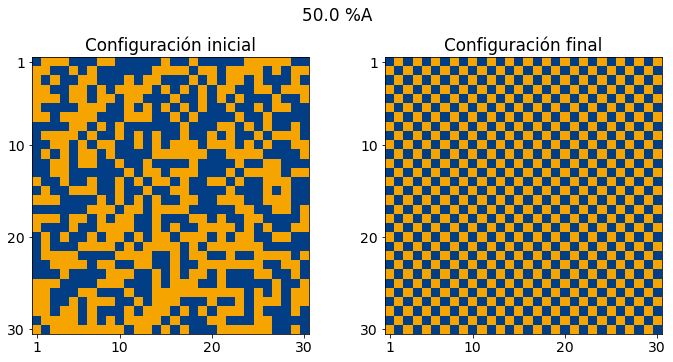

In [10]:
print()
print('\033[1m Estado inicial:                              Estado Final:  \033[0m')
print('\033[1m \033[33m    Energía    \033[0m  %5.2f                      \033[1m \033[33m    Energía    \033[0m  %5.2f' % (E0, E))
print('\033[1m \033[33m    "Magnet."  \033[0m  %5.2f                       \033[1m \033[33m   "Magnet."  \033[0m  %5.2f' % (M, M))
print()

plt.rc('figure', figsize=(10, 5))
fig = plt.figure()
fig.clf()
fig.suptitle(str(np.round(xA*100))+' %A')
ax = fig.subplots(1, 2)

ax[0].imshow(conf0, cmap=ElMasGrande)
ax[0].set_title('Configuración inicial')
ax[0].set_xticks([0, 9, 19, 29], [1, 10, 20, 30])
ax[0].set_yticks([0, 9, 19, 29], [1, 10, 20, 30])

ax[1].imshow(conf, cmap=ElMasGrande)
ax[1].set_title('Configuración final')
ax[1].set_xticks([0, 9, 19, 29], [1, 10, 20, 30])
ax[1].set_yticks([0, 9, 19, 29], [1, 10, 20, 30])

fig.tight_layout(pad=1)
plt.savefig(str(np.round(xA*100))+'-1.png')

### Evolución con la temperatura


     Temp. de transformación    1.1640



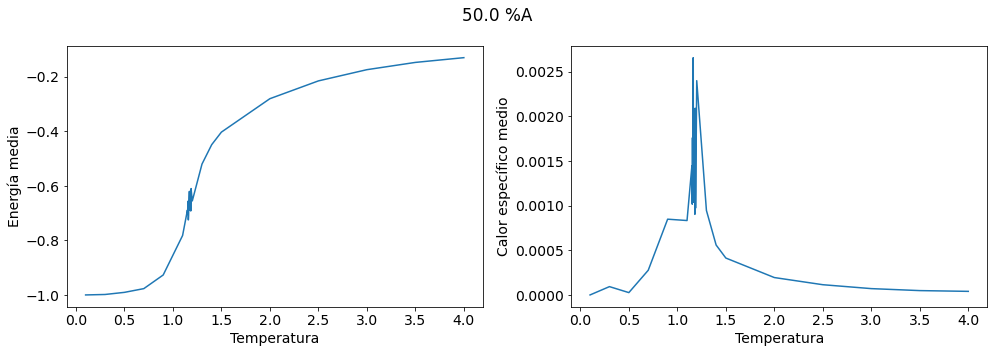

In [11]:
MaxY = max(CalorEsp)
MaxX = Temps[CalorEsp.index(MaxY)]

print()
print('\033[1m \033[33m    Temp. de transformación \033[0m   %6.4f' % MaxX)
print()

plt.rc('figure', figsize=(14, 5))
fig = plt.figure()
fig.clf()
fig.suptitle(str(np.round(xA*100))+' %A')
ax = fig.subplots(1, 2)

ax[0].plot(Temps, Energia)
ax[0].set_xlabel('Temperatura')
ax[0].set_ylabel('Energía media')

ax[1].plot(Temps, CalorEsp)
ax[1].set_xlabel('Temperatura')
ax[1].set_ylabel('Calor específico medio')

fig.tight_layout(pad=1)
plt.savefig(str(np.round(xA*100))+'-2.png')